# 라이브러리 import

In [27]:
import pandas as pd
from pandas_gbq import read_gbq
import numpy as np
from joblib import Parallel, delayed
import ast

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from kneed import KneeLocator
from sklearn.metrics import silhouette_score, davies_bouldin_score

from pyspark.sql import SparkSession 

import dotenv
from google.oauth2 import service_account

# 데이터 불러오기

## pandas

In [2]:
# BigQuery에 업로드된 데이터 불러오기 (pandas)
def load_data_from_bigquery(query):
    try:
        df = read_gbq(query,
                      project_id=dotenv.get_key(dotenv.find_dotenv(), "GOOGLE_PROJECT_ID"),
                      dialect='standard'
                      )
        return df
    except Exception as e:
        print(f"Error loading data from BigQuery: {e}")
        return None

In [3]:
votes_tables = load_data_from_bigquery("SELECT table_name FROM `votes.INFORMATION_SCHEMA.TABLES`;")

Downloading: 100%|██████████|


In [4]:
hackle_tables = load_data_from_bigquery("SELECT table_name FROM `hackle.INFORMATION_SCHEMA.TABLES`;")

Downloading: 100%|██████████|


## spark

In [3]:
# BigQuery에 업로드된 데이터 불러오기 (spark)
def load_data_from_bigquery_spark(query):
    spark = SparkSession.builder \
        .appName("BigQuery to Spark") \
        .config("spark.jars.packages", "com.google.cloud.spark:spark-bigquery-with-dependencies_2.12:0.24.0") \
        .getOrCreate()
    try:
        credentials = service_account.Credentials.from_service_account_file(
            dotenv.get_key(dotenv.find_dotenv(), "GOOGLE_APPLICATION_CREDENTIALS")
        )
        df = spark.read.format("bigquery") \
            .option("credentials", credentials) \
            .option("query", query) \
            .load()
        return df
    except Exception as e:
        print(f"Error loading data from BigQuery with Spark: {e}")
        return None

In [4]:
votes_tables = load_data_from_bigquery_spark("SELECT table_name FROM `votes.INFORMATION_SCHEMA.TABLES`;")

KeyboardInterrupt: 

In [ ]:
hackle_tables = load_data_from_bigquery_spark("SELECT table_name FROM `hackle.INFORMATION_SCHEMA.TABLES`;")

# 기본 통계량 함수 작성란

In [6]:
# 기본 통계량 (데이터의 크기, 타입, 결측치, describe 내용 확인) 출력 함수
def basic_information(df):
    print(f'data shape : {df.shape}')
    
    basic_info_df = pd.DataFrame(data=df.dtypes, columns=['dtypes'])
    basic_info_df['missing'] = df.isnull().sum().values
    basic_info_df['missing_rate (%)'] = df.isnull().sum().values / len(df) * 100
    basic_info_df['nunique'] = df.nunique().values

    # describe 통계량 (수치형/범주형 포함)
    desc_df = df.describe(include='all').transpose()

    # 수치형 항목만 해당되는 통계량 추가
    for col in ['mean', 'std', 'min','25%', '50%', '75%', 'max']:
        if col in desc_df.columns:
            basic_info_df[col] = desc_df[col]

    # 최빈값 및 해당 최빈값의 count
    basic_info_df['mode'] = {col: df[col].mode(dropna=True).iloc[0] if not df[col].mode(dropna=True).empty else None for col in df.columns}
    basic_info_df['mode_counts'] = {col: df[col].value_counts().max() if not df[col].value_counts().empty else 0 for col in df.columns}

    return basic_info_df

# votes 데이터베이스 확인

## head 출력

In [7]:
# votes 테이블의 기본 정보 출력
for table in votes_tables['table_name']:
    print(f"Table: {table}")
    query = f"SELECT * FROM `votes.{table}` LIMIT 5;"
    display(load_data_from_bigquery(query))

Table: polls_question
Downloading: 100%|██████████|


,id,question_text,created_at
0,99,가장 신비한 매력이 있는 사람은?,2023-03-31 15:22:53
1,100,"""이 사람으로 한 번 살아보고 싶다"" 하는 사람은?",2023-03-31 15:22:53
2,101,미래의 틱톡커는?,2023-03-31 15:22:54
3,102,여기서 제일 특이한 친구는?,2023-03-31 15:22:54
4,103,가장 지켜주고 싶은 사람은?,2023-03-31 15:22:55


Table: accounts_attendance
Downloading: 100%|██████████|


,id,attendance_date_list,user_id
0,7923,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1355335
1,38921,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",892265
2,777,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",913054
3,6557,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",947077
4,2534,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1233366


Table: polls_questionpiece
Downloading: 100%|██████████|


,id,is_voted,created_at,question_id,is_skipped
0,998458,1,2023-04-28 12:27:22,252,0
1,998459,1,2023-04-28 12:27:22,244,0
2,998460,1,2023-04-28 12:27:22,183,0
3,998461,1,2023-04-28 12:27:22,101,0
4,998462,1,2023-04-28 12:27:22,209,0


Table: accounts_failpaymenthistory
Downloading: 100%|██████████|


,id,productId,phone_type,created_at,user_id
0,20,None,I,2023-05-15 16:26:51,1153256
1,21,None,I,2023-05-16 03:16:37,1230712
2,22,None,I,2023-05-16 06:40:04,1277817
3,23,None,I,2023-05-16 07:40:32,1254768
4,26,None,I,2023-05-16 11:31:51,1189806


Table: polls_questionset
Downloading: 100%|██████████|


,id,question_piece_id_list,opening_time,status,created_at,user_id
0,7993167,"[79931958, 79931960, 79931962, 79931966, 79931...",2023-05-17 00:22:16,C,2023-05-16 23:42:16,841333
1,8298931,"[82989582, 82989587, 82989592, 82989596, 82989...",2023-05-17 09:54:57,C,2023-05-17 09:14:57,845326
2,20617202,"[206172781, 206172782, 206172783, 206172784, 2...",2023-07-29 16:13:18,C,2023-07-29 15:33:18,847375
3,20017608,"[200176841, 200176842, 200176843, 200176844, 2...",2023-06-16 15:13:10,C,2023-06-16 14:33:10,849438
4,20673673,"[206737491, 206737492, 206737493, 206737494, 2...",2023-08-10 09:20:44,C,2023-08-10 08:40:44,849451


Table: accounts_user_contacts
Downloading: 100%|██████████|


,id,contacts_count,invite_user_id_list,user_id
0,1817700,1,[887254],945228
1,294336,4,[876443],971857
2,161592,5,[879138],890096
3,500886,5,[858396],871299
4,1270942,5,[1548321],1555658


Table: accounts_group
Downloading: 100%|██████████|


,id,grade,class_num,school_id
0,1,1,1,1
1,227,1,20,1
2,660,1,7,1
3,1184,1,5,1
4,1191,1,8,1


Table: accounts_user
Downloading: 100%|██████████|


,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
0,831956,1,1,None,600,"[1292473, 913158, 1488461, 1064695, 1043565, 1...",0,2023-03-29 03:44:14.047130,[],[],N,0,0,0,0,NaN
1,831962,0,0,F,2248,"[833025, 832642, 982531, 879496, 838541, 83752...",1,2023-03-29 05:18:56.162368,[],[],N,253,40878,5499,110,12.0
2,832151,0,0,M,1519,"[838785, 982531, 882567, 879496, 838541, 83649...",0,2023-03-29 12:56:34.989468,[],[],N,0,37,0,47,1.0
3,832340,0,0,F,57,"[841345, 982531, 838785, 963714, 882567, 83252...",1,2023-03-29 12:56:35.020790,[],[],N,0,19,0,21,1.0
4,832520,0,0,M,1039,"[874050, 849763, 874212, 844297, 838541, 84004...",0,2023-03-29 12:56:35.049311,[],[],N,0,29,0,15,12.0


Table: accounts_blockrecord
Downloading: 100%|██████████|


,id,reason,created_at,block_user_id,user_id
0,1,그냥...,2023-05-04 23:01:53,867483,878476
1,6,그냥...,2023-05-05 05:21:52,883696,883511
2,7,그냥...,2023-05-05 06:40:34,871349,870177
3,14,그냥...,2023-05-05 13:04:52,885794,879662
4,21,그냥...,2023-05-05 15:36:34,887434,881108


Table: accounts_userwithdraw
Downloading: 100%|██████████|


,id,reason,created_at
0,47374,admin,2023-05-28 15:07:43
1,47376,admin,2023-05-29 06:22:53
2,47377,admin,2023-05-29 06:43:36
3,47379,admin,2023-05-29 08:33:47
4,47380,admin,2023-05-29 09:15:01


Table: accounts_friendrequest
Downloading: 100%|██████████|


,id,status,created_at,updated_at,receive_user_id,send_user_id
0,10803451,A,2023-05-16 11:47:10,2023-05-17 13:55:36,1186094,1323197
1,10803477,A,2023-05-16 11:47:10,2023-05-16 14:23:29,1276512,1320204
2,10805049,A,2023-05-16 11:48:18,2023-05-16 13:02:12,1320432,1115450
3,10806004,A,2023-05-16 11:49:01,2023-05-16 11:52:33,1321751,1322938
4,10807567,A,2023-05-16 11:50:07,2023-05-16 15:01:54,1145230,1286765


Table: event_receipts
Downloading: 100%|██████████|


,id,created_at,event_id,user_id,plus_point
0,2,2023-06-22 09:25:16,1,1193618,500
1,3,2023-06-22 09:38:53,1,928351,500
2,4,2023-06-22 10:32:15,1,904872,500
3,5,2023-06-22 13:03:06,1,974697,500
4,6,2023-06-22 13:40:38,1,1168260,500


Table: polls_questionreport
Downloading: 100%|██████████|


,id,reason,created_at,question_id,user_id
0,4852,그냥 싫어,2023-05-07 12:14:13,99,894226
1,4971,그냥 싫어,2023-05-07 13:43:20,99,906185
2,5389,그냥 싫어,2023-05-08 02:16:54,99,944035
3,7884,그냥 싫어,2023-05-09 14:19:10,99,981801
4,11094,그냥 싫어,2023-05-11 13:26:01,99,887923


Table: events
Downloading: 100%|██████████|


,id,title,plus_point,event_type,is_expired,created_at
0,1,코드잇 은행 가입 이벤트,500,FCFS,1,2023-06-20 11:56:38
1,3,예고 영상 기대평 이벤트,500,FCFS,1,2023-09-24 17:05:59
2,2,코드잇 멤버십 가입 이벤트,1000,FCFS,1,2023-08-08 07:43:45


Table: accounts_paymenthistory
Downloading: 100%|██████████|


,id,productId,phone_type,created_at,user_id
0,89584,heart.777,A,2023-06-06 04:58:49,835888
1,89585,heart.200,A,2023-06-06 04:59:22,835888
2,2403,heart.777,A,2023-05-14 04:22:44,837641
3,79774,heart.777,A,2023-05-29 10:13:55,837737
4,195,heart.777,A,2023-05-13 23:10:10,837842


Table: accounts_userquestionrecord
Downloading: 100%|██████████|


,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
0,945319,I,2023-04-29 13:22:05,849995,132,851717,1213085,1,P,2023-05-06 10:31:30,0,3
1,978922,I,2023-04-29 14:49:06,849922,180,849450,1235436,1,N,2023-04-29 14:49:06,0,3
2,1095692,I,2023-04-30 03:29:48,850031,132,850229,1395859,1,N,2023-04-30 03:29:48,0,3
3,1167181,I,2023-04-30 07:43:10,856172,116,857422,1509130,1,N,2023-04-30 07:43:10,0,3
4,1171173,I,2023-04-30 07:58:36,855039,132,855117,1511169,1,N,2023-04-30 07:58:36,0,3


Table: accounts_school
Downloading: 100%|██████████|


,id,address,student_count,school_type
0,4,충청북도 충주시,239,H
1,6,충청북도 충주시,200,H
2,7,충청북도 충주시,114,H
3,13,충청북도 충주시,80,H
4,16,충청북도 충주시,143,H


Table: accounts_pointhistory
Downloading: 100%|██████████|


,id,delta_point,created_at,user_id,user_question_record_id
0,145203381,-500,2023-05-18 12:24:21,1228792,69029243.0
1,145379907,-500,2023-05-18 12:33:59,1159163,71772936.0
2,145400847,-500,2023-05-18 12:35:09,1243371,40846522.0
3,145439633,-500,2023-05-18 12:37:14,1273533,70891824.0
4,145467849,-500,2023-05-18 12:38:46,1295255,69224499.0


Table: accounts_nearbyschool
Downloading: 100%|██████████|


,id,distance,nearby_school_id,school_id
0,119021,0.004564,6,7
1,119022,0.010787,13,7
2,119023,0.012928,20,7
3,119024,0.013590,4,7
4,119025,0.014122,24,7


Table: polls_usercandidate
Downloading: 100%|██████████|


,id,created_at,question_piece_id,user_id
0,3088872,2023-04-28 12:27:49,998458,849444
1,3088873,2023-04-28 12:27:49,998458,849454
2,3088874,2023-04-28 12:27:49,998458,849460
3,3088875,2023-04-28 12:27:49,998458,849469
4,3088964,2023-04-28 12:28:02,998459,849446


Table: accounts_timelinereport
Downloading: 100%|██████████|


,id,reason,created_at,reported_user_id,user_id,user_question_record_id
0,4794,광고,2023-05-10 14:27:44,917587,1084275,18272641
1,7168,광고,2023-05-12 14:54:46,967873,1184397,28992803
2,7169,광고,2023-05-12 14:54:52,967873,1184397,28992803
3,9998,광고,2023-05-14 16:49:58,1207784,1214760,46645583
4,10257,광고,2023-05-15 06:08:04,1250642,1228033,48820574


## 기본 정보 출력

In [8]:
# votes 테이블의 요약, 결측치, 타입 등 기본 정보 출력
for table in votes_tables['table_name']:
    print(f"Table: {table}")
    query = f"SELECT * FROM `votes.{table}`;"
    display(basic_information(load_data_from_bigquery(query)))

Table: polls_question
Downloading: 100%|██████████|
data shape : (5025, 3)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,5025,2619.897512,1452.438472,99.0,1365.0,2621.0,3877.0,5133.0,99,1
question_text,object,0,0.0,3903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,vote,56
created_at,datetime64[us],0,0.0,644,2023-05-26 17:49:11.666268,NaN,2023-03-31 15:22:53,2023-05-15 14:03:03,2023-06-02 08:06:53,2023-06-06 06:10:14,2023-06-06 06:15:52,2023-06-06 06:15:42,82


Table: accounts_attendance
Downloading: 100%|██████████|
data shape : (349637, 3)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,349637,180550.143772,104168.322237,1.0,90432.0,180749.0,270674.0,360505.0,1,1
attendance_date_list,object,0,0.0,128837,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],20945
user_id,Int64,0,0.0,349637,1247187.288568,212798.63273,832151.0,1065813.0,1261234.0,1437486.0,1583730.0,832151,1


Table: polls_questionpiece
Downloading: 100%|██████████|
data shape : (1265476, 5)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,1265476,76580010.680432,59129238.708104,998458.0,20292595.75,68465330.0,121266195.5,208385230.0,998458,1
is_voted,Int64,0,0.0,2,0.963027,0.188697,0.0,1.0,1.0,1.0,1.0,1,1218687
created_at,datetime64[us],0,0.0,162155,2023-05-17 13:39:58.427318,NaN,2023-04-28 12:27:22,2023-05-09 21:50:54,2023-05-15 14:18:31.500000,2023-05-22 09:56:44,2024-05-07 11:32:30,2023-05-20 14:45:37,37
question_id,Int64,0,0.0,4944,713.359777,670.681537,99.0,278.0,477.0,982.0,5133.0,170,2030
is_skipped,Int64,0,0.0,2,0.000891,0.029829,0.0,0.0,0.0,0.0,1.0,0,1264349


Table: accounts_failpaymenthistory
Downloading: 100%|██████████|
data shape : (163, 5)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.000000,163,89.828221,48.494316,6.0,48.5,89.0,131.5,174.0,6,1
productId,object,107,65.644172,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,heart.777,49
phone_type,object,0,0.000000,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I,107
created_at,datetime64[us],0,0.000000,162,2023-05-27 11:32:20.828220,NaN,2023-05-14 05:49:22,2023-05-18 11:34:05,2023-05-22 08:54:33,2023-05-29 12:58:21.500000,2023-09-17 09:12:53,2023-09-17 09:12:53,2
user_id,Int64,0,0.000000,160,1263684.779141,182463.595784,834112.0,1152703.5,1273301.0,1398432.0,1575434.0,927108,2


Table: polls_questionset
Downloading: 100%|██████████|
data shape : (158384, 6)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,158384,7641273.830696,5943689.973322,99817.0,1953393.25,6757335.0,12175103.25,20838446.0,99817,1
question_piece_id_list,object,0,0.0,158384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[1000018, 1000019, 1000020, 1000021, 1000022, ...",1
opening_time,datetime64[us],0,0.0,151839,2023-05-17 13:25:41.180415,NaN,2023-04-28 12:27:22,2023-05-09 15:46:49.500000,2023-05-15 13:43:55.500000,2023-05-22 11:43:24.500000,2024-05-07 12:12:30,2023-04-29 11:22:43,4
status,object,0,0.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,153411
created_at,datetime64[us],0,0.0,151940,2023-05-17 12:43:12.170648,NaN,2023-04-28 12:27:23,2023-05-09 14:58:05.500000,2023-05-15 13:04:46.500000,2023-05-22 11:04:03,2024-05-07 11:32:30,2023-05-06 14:24:06,4
user_id,Int64,0,0.0,4972,1106751.980939,207861.209058,838023.0,884747.0,1117999.0,1261250.0,1583358.0,952220,370


Table: accounts_user_contacts
Downloading: 100%|██████████|
data shape : (5063, 4)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,5063,2840906.78807,2895428.210201,259.0,747597.0,1580135.0,4201597.5,14608267.0,259,1
contacts_count,Int64,0,0.0,87,25.986174,13.601434,0.0,16.0,24.0,34.0,114.0,19,191
invite_user_id_list,object,0,0.0,928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],3905
user_id,Int64,0,0.0,5063,1114789.066364,218770.170387,847375.0,885515.5,1119987.0,1278826.0,1583629.0,847375,1


Table: accounts_group
Downloading: 100%|██████████|
data shape : (84515, 4)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,84515,42279.376087,24400.96263,1.0,21147.5,42279.0,63411.5,84546.0,1,1
grade,Int64,0,0.0,5,2.113992,0.754896,1.0,2.0,2.0,3.0,20.0,2,35581
class_num,Int64,0,0.0,22,5.318606,4.089901,0.0,2.0,4.0,7.0,41.0,1,12125
school_id,Int64,0,0.0,5604,3079.496468,1675.036093,1.0,1752.0,3023.0,4620.0,5965.0,3283,49


Table: accounts_user
Downloading: 100%|██████████|
data shape : (677085, 16)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.000000,677085,1212969.125237,213897.052019,831956.0,1028075.0,1211729.0,1397906.0,1583733.0,831956,1
is_superuser,Int64,0,0.000000,2,0.000003,0.001719,0.0,0.0,0.0,0.0,1.0,0,677083
is_staff,Int64,0,0.000000,2,0.000004,0.002105,0.0,0.0,0.0,0.0,1.0,0,677082
gender,object,2,0.000295,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,396665
point,Int64,0,0.000000,14258,3039.144837,1076019.94305,0.0,400.0,965.0,2183.0,885000006.0,300,8936
friend_id_list,object,0,0.000000,674117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],2874
is_push_on,Int64,0,0.000000,2,0.843098,0.363709,0.0,1.0,1.0,1.0,1.0,1,570849
created_at,datetime64[us],0,0.000000,677082,2023-05-15 22:46:01.709212,NaN,2023-03-29 03:44:14.047130,2023-05-09 01:35:23.126587,2023-05-13 10:50:57.476214,2023-05-20 07:49:47.800350,2024-05-09 08:31:17.710824,2023-05-12 04:20:25.151806,2
block_user_id_list,object,0,0.000000,11685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],664042
hide_user_id_list,object,0,0.000000,74995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],598352


Table: accounts_blockrecord
Downloading: 100%|██████████|
data shape : (19482, 5)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,19482,12694.563495,7220.338199,1.0,6514.25,12731.0,18984.75,25361.0,1,1
reason,object,0,0.0,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,모르는 사람임,9640
created_at,datetime64[us],0,0.0,19364,2023-05-25 19:12:26.516579,NaN,2023-05-04 23:01:53,2023-05-14 02:19:01,2023-05-22 11:37:20,2023-05-28 11:04:33,2024-05-06 13:03:37,2023-05-09 11:55:43,3
block_user_id,Int64,0,0.0,16240,1183575.866235,204951.681645,832740.0,1001336.0,1173390.0,1357468.25,1582869.0,898020,76
user_id,Int64,0,0.0,12552,1175780.405708,204318.852573,837615.0,989041.0,1160725.5,1345757.75,1583612.0,1526194,171


Table: accounts_userwithdraw
Downloading: 100%|██████████|
data shape : (70764, 3)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,70764,35499.063154,20439.604727,42.0,17803.75,35498.5,53199.25,70893.0,42,1
reason,object,0,0.0,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,기타 이유,40301
created_at,datetime64[us],0,0.0,69888,2023-06-12 06:34:26.762464,NaN,2023-03-29 13:22:12,2023-05-12 06:28:54.250000,2023-05-20 15:50:53.500000,2023-06-14 12:13:03.500000,2024-05-09 08:49:06,2023-05-07 12:58:16,3


Table: accounts_friendrequest
Downloading: 100%|██████████|
data shape : (17147175, 6)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,17147175,9855564.676715,5675224.681984,7.0,4940746.5,9810449.0,14775984.5,19692979.0,7,1
status,object,0,0.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,12878407
created_at,datetime64[us],0,0.0,2349736,2023-05-17 19:14:14.416624,NaN,2023-04-17 18:29:11,2023-05-10 10:53:21,2023-05-15 10:38:56,2023-05-22 14:28:30,2024-05-09 09:21:47,2023-05-07 10:30:02,668
updated_at,datetime64[us],0,0.0,2941770,2023-05-19 03:18:26.881182,NaN,2023-04-17 18:29:11,2023-05-11 03:51:13,2023-05-16 10:24:42,2023-05-23 21:37:16,2024-05-09 09:21:47,2023-05-07 10:30:02,216
receive_user_id,Int64,0,0.0,660841,1154812.124189,201954.707116,831962.0,973708.0,1138343.0,1317869.0,1583731.0,909685,218
send_user_id,Int64,0,0.0,649072,1215895.337257,214348.591142,831962.0,1029359.0,1213751.0,1405678.0,1583732.0,1533716,1816


Table: event_receipts
Downloading: 100%|██████████|
data shape : (309, 5)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,309,160.964401,92.065029,2.0,82.0,161.0,239.0,321.0,2,1
created_at,datetime64[us],0,0.0,309,2023-07-24 01:53:59.954692,NaN,2023-06-22 09:25:16,2023-07-10 16:58:20,2023-07-20 12:24:28,2023-07-29 09:38:22,2023-11-21 12:03:02,2023-06-22 09:25:16,1
event_id,Int64,0,0.0,3,1.249191,0.563536,1.0,1.0,1.0,1.0,3.0,1,252
user_id,Int64,0,0.0,308,1179714.640777,217198.132845,837836.0,999816.0,1139491.0,1325911.0,1579064.0,1577954,2
plus_point,Int64,0,0.0,2,559.87055,162.592579,500.0,500.0,500.0,500.0,1000.0,500,272


Table: polls_questionreport
Downloading: 100%|██████████|
data shape : (51424, 5)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,51424,28027.358587,16163.108294,1.0,14020.75,28047.5,42084.25,55767.0,1,1
reason,object,0,0.0,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,그냥 싫어,28446
created_at,datetime64[us],0,0.0,50693,2023-05-21 22:12:41.641121,NaN,2023-04-19 06:20:35,2023-05-13 01:36:21.250000,2023-05-18 14:33:45,2023-05-26 08:45:25,2024-05-05 14:56:25,2023-05-21 10:01:53,4
question_id,Int64,0,0.0,3135,733.099098,666.021729,99.0,305.0,494.0,1021.0,5110.0,111,988
user_id,Int64,0,0.0,22171,1168246.717642,208247.108978,832340.0,978481.0,1160251.0,1351295.0,1583634.0,1441146,865


Table: events
Downloading: 100%|██████████|
data shape : (3, 6)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,3,2.0,1.0,1.0,1.5,2.0,2.5,3.0,1,1
title,object,0,0.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,예고 영상 기대평 이벤트,1
plus_point,Int64,0,0.0,2,666.666667,288.675135,500.0,500.0,500.0,750.0,1000.0,500,2
event_type,object,0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FCFS,3
is_expired,Int64,0,0.0,1,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1,3
created_at,datetime64[us],0,0.0,3,2023-08-07 20:15:27.333333,NaN,2023-06-20 11:56:38,2023-07-14 21:50:11.500000,2023-08-08 07:43:45,2023-09-01 00:24:52,2023-09-24 17:05:59,2023-06-20 11:56:38,1


Table: accounts_paymenthistory
Downloading: 100%|██████████|
data shape : (95140, 5)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,95140,49136.797572,28366.854064,6.0,24531.75,49176.5,73740.25,98078.0,6,1
productId,object,0,0.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,heart.777,57873
phone_type,object,0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I,61632
created_at,datetime64[us],0,0.0,90243,2023-05-27 21:47:32.003742,NaN,2023-05-13 21:28:34,2023-05-16 11:48:44.750000,2023-05-21 12:40:45.500000,2023-05-27 13:02:52.250000,2024-05-08 14:12:45,2023-09-13 16:36:26,6
user_id,Int64,0,0.0,59192,1256911.87799,191124.313895,833041.0,1116654.0,1270988.0,1417660.0,1583632.0,1527451,60


Table: accounts_userquestionrecord
Downloading: 100%|██████████|
data shape : (1217558, 12)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,1217558,59572979.018822,46081927.886242,771777.0,15539652.75,53026805.0,94809596.25,161666464.0,771777,1
status,object,0,0.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,1156322
created_at,datetime64[us],0,0.0,916830,2023-05-17 12:51:25.947101,NaN,2023-04-28 12:27:49,2023-05-10 01:42:11,2023-05-15 15:43:01.500000,2023-05-22 11:01:03.750000,2024-05-08 01:36:18,2023-05-13 02:14:18,9
chosen_user_id,Int64,0,0.0,15426,1092603.584565,202758.478202,833112.0,883692.0,1091749.0,1235698.0,1579422.0,913265,1239
question_id,Int64,0,0.0,4805,684.389544,625.039927,99.0,275.0,469.0,942.0,5133.0,170,1996
user_id,Int64,0,0.0,4849,1105789.856924,206270.380697,838023.0,884619.0,1117537.0,1259186.0,1583358.0,849103,2786
question_piece_id,Int64,0,0.0,1217558,74132114.86932,57572369.476189,998458.0,18541420.5,66168425.5,117673456.75,208351468.0,998458,1
has_read,Int64,0,0.0,2,0.555153,0.496949,0.0,0.0,1.0,1.0,1.0,1,675931
answer_status,object,0,0.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,1097932
answer_updated_at,datetime64[us],0,0.0,915926,2023-05-17 13:44:38.920360,NaN,2023-04-28 12:27:49,2023-05-10 02:38:44.750000,2023-05-15 16:29:08.500000,2023-05-22 11:41:54.750000,2024-05-08 01:36:18,2023-05-14 13:23:01,9


Table: accounts_school
Downloading: 100%|██████████|
data shape : (5951, 4)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,5951,2981.026046,1719.08402,4.0,1493.5,2981.0,4469.5,5965.0,4,1
address,object,0,0.0,278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,경기도 화성시,78
student_count,Int64,0,0.0,433,113.772979,102.863428,0.0,16.0,97.0,183.0,578.0,0,387
school_type,object,0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,3290


Table: accounts_pointhistory
Downloading: 100%|██████████|
data shape : (2338918, 5)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.000000,2338918,126536375.311562,96109918.359378,790629.0,41125051.25,112397137.5,198205120.5,340672375.0,790629,1
delta_point,Int64,0,0.000000,44,0.861086,58.858493,-1000.0,7.0,10.0,13.0,1000.0,6,203479
created_at,datetime64[us],0,0.000000,985371,2023-05-18 03:06:43.825683,NaN,2023-04-28 12:27:49,2023-05-11 04:37:02,2023-05-16 07:29:11,2023-05-22 13:47:48.750000,2024-05-08 01:36:18,2023-05-14 15:01:54,18
user_id,Int64,0,0.000000,5037,1111554.416328,202442.944236,838023.0,886189.0,1126012.0,1260221.0,1583358.0,849103,2976
user_question_record_id,float64,2992,0.127922,1217554,61418034.598117,45319697.06178,771777.0,20885605.5,55406136.0,95558554.0,161666464.0,3398691.0,6


Table: accounts_nearbyschool
Downloading: 100%|██████████|
data shape : (59500, 4)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,59500,148770.5,17176.314845,119021.0,133895.75,148770.5,163645.25,178520.0,119021.0,1
distance,float64,0,0.0,32006,0.055338,0.604024,0.0,0.011484,0.021658,0.064555,49.296594,0.0,6214
nearby_school_id,Int64,0,0.0,5950,2976.695882,1706.965231,4.0,1518.0,2973.0,4448.0,5964.0,4497.0,22
school_id,Int64,0,0.0,5950,2980.524538,1718.663078,4.0,1493.0,2980.5,4469.0,5964.0,4.0,10


Table: polls_usercandidate
Downloading: 100%|██████████|
data shape : (4769609, 4)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,4769609,238868397.391241,184489263.091847,3088872.0,62703391.0,212670022.0,380021511.0,646672584.0,3088872,1
created_at,datetime64[us],0,0.0,917071,2023-05-17 13:57:52.437727,NaN,2023-04-28 12:27:49,2023-05-10 02:49:19,2023-05-15 16:15:12,2023-05-22 11:33:33,2024-05-08 01:36:18,2023-05-17 13:45:43,44
question_piece_id,Int64,0,0.0,1217589,74302481.038724,57619589.580503,998458.0,18916946.0,66396553.0,117887593.0,208351468.0,9494270,16
user_id,Int64,0,0.0,19994,1090240.982971,201819.002037,833112.0,883590.0,1087460.0,1233969.0,1580629.0,860304,4226


Table: accounts_timelinereport
Downloading: 100%|██████████|
data shape : (208, 6)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,208,9786.269231,5713.767759,28.0,6123.75,10095.0,14182.25,23108.0,28,1
reason,object,0,0.0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,허위 사실 언급,80
created_at,datetime64[us],0,0.0,208,2023-05-15 08:13:50.278846,NaN,2023-05-06 04:44:57,2023-05-11 16:41:43.500000,2023-05-15 01:23:29,2023-05-18 18:01:18,2023-06-02 08:30:06,2023-05-06 04:44:57,1
reported_user_id,Int64,0,0.0,125,1132496.875,169412.066968,837235.0,966470.25,1144432.0,1225963.0,1562736.0,1138757,15
user_id,Int64,0,0.0,115,1159945.668269,180095.938183,834089.0,967120.25,1184397.0,1291813.0,1548002.0,1343904,19
user_question_record_id,Int64,0,0.0,163,49325579.326923,33112807.364359,3920588.0,24611783.5,47403268.0,71795781.0,140765885.0,78776644,14


# hackle 데이터베이스 확인

## head 출력

In [9]:
# hackle 테이블의 기본 정보 출력
for table in hackle_tables['table_name']:
    print(f"Table: {table}")
    query = f"SELECT * FROM `hackle.{table}` LIMIT 5;"
    display(load_data_from_bigquery(query))

Table: device_properties
Downloading: 100%|██████████|


,id,device_id,device_model,device_vendor
0,178797,b5a029f8-39fb-487f-8607-0ff2a65f1fe7,Z4PRO,APEX
1,220605,e0034fb8-d4a2-4c28-9c9b-fab4c4762f69,Z4PRO,APEX
2,75889,4d1b5295-29ba-4606-b4bd-7f455ade35fd,Tab_MyPen_P1,Alldocube
3,34028,228937fd-0675-4ec9-99f2-d8d7460e34d7,KFMAWI,Amazon
4,43876,2c797959-01fd-4f45-8b3a-1dc34fec4951,KFMAWI,Amazon


Table: user_properties
Downloading: 100%|██████████|


,user_id,class,gender,grade,school_id
0,1236848,1,M,1,1
1,1437875,1,M,1,1
2,1572211,1,M,1,1
3,1577131,1,M,1,1
4,1577930,1,M,1,1


Table: hackle_events
Downloading: 100%|██████████|


,event_id,event_datetime,event_key,session_id,id,item_name,page_name,friend_count,votes_count,heart_balance,question_id
0,a4490697-42d9-47ad-abde-5f05a57629f8,2023-08-06 22:03:23,$session_start,5d45bf15-82eb-47e8-917c-f779ca2c35bc,a4490697-42d9-47ad-abde-5f05a57629f8,,,NaN,NaN,NaN,NaN
1,a4496ff1-1584-4705-92f3-e971fdec2de1,2023-08-06 06:02:04,$session_end,7Yy9L6IvlZWO6YQyGYLhthRj29p1,a4496ff1-1584-4705-92f3-e971fdec2de1,,,NaN,NaN,NaN,NaN
2,a45070d1-b1fa-4dcd-a369-42fb17a5271b,2023-08-06 20:33:22,launch_app,4BAAE5D5-FCEE-4995-B65C-822B69B0CD8D,a45070d1-b1fa-4dcd-a369-42fb17a5271b,,,NaN,NaN,NaN,NaN
3,a4530ae5-373f-4f0d-b89a-8d6de24455e3,2023-07-29 18:28:41,$session_start,0lwba1Cg9GP3ScQGQ7sdOe5ws5n1,a4530ae5-373f-4f0d-b89a-8d6de24455e3,,,NaN,NaN,NaN,NaN
4,a453db5c-cc95-4ea4-b47a-458a177dbce7,2023-07-18 22:13:34,launch_app,CE87B688-4149-4D9D-AAA9-6558CC27D4A0,a453db5c-cc95-4ea4-b47a-458a177dbce7,,,NaN,NaN,NaN,NaN


Table: hackle_properties
Downloading: 100%|██████████|


,id,session_id,user_id,language,osname,osversion,versionname,device_id
0,225279,aa2f0ec2-6e64-4937-88c0-139dc1e6ba3a,,ko,Android,11,1.0.0,aa2f0ec2-6e64-4937-88c0-139dc1e6ba3a
1,150431,f54427dc-87fc-4a71-9f22-351ebc3d83de,,ko,Android,11,1.2.1,f54427dc-87fc-4a71-9f22-351ebc3d83de
2,212190,e24fae5a-0896-4149-ac68-775ecd89c90e,,ko,Android,11,1.2.1,e24fae5a-0896-4149-ac68-775ecd89c90e
3,347659,752SqR0xcyWltcAkQzGs8ZNhvju1,,ko,Android,10,1.2.10,7b1d355a-1b31-42a8-bddc-d9f54a81e49b
4,360622,0c155764-4c9d-4e66-92c4-e6c1080c83f9,,ko,Android,10,1.2.10,0c155764-4c9d-4e66-92c4-e6c1080c83f9


## 기본 정보 출력

In [10]:
# hackle 테이블의 요약, 결측치, 타입 등 기본 정보 출력
for table in hackle_tables['table_name']:
    print(f"Table: {table}")
    query = f"SELECT * FROM `hackle.{table}`;"
    display(basic_information(load_data_from_bigquery(query)))

Table: device_properties
Downloading: 100%|██████████|
data shape : (252380, 4)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,252380,126190.5,72855.974806,1.0,63095.75,126190.5,189285.25,252380.0,1,1
device_id,object,0,0.0,251720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0006bed8-512b-48f9-9b33-f79bb1e225a8,2
device_model,object,0,0.0,522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"iPhone14,5",27656
device_vendor,object,0,0.0,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Apple,174444


Table: user_properties
Downloading: 100%|██████████|
data shape : (230819, 5)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
user_id,object,0,0.0,230819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000000,1
class,Int64,0,0.0,20,4.594999,3.151979,1.0,2.0,4.0,6.0,20.0,1,36580
gender,object,0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,F,132610
grade,Int64,0,0.0,3,2.002197,0.762048,1.0,1.0,2.0,3.0,3.0,2,96778
school_id,Int64,0,0.0,5023,3083.383335,1711.671162,1.0,1594.0,3138.0,4640.0,5964.0,4917,206


Table: hackle_events


C:\Users\lento\AppData\Local\Temp\ipykernel_16612\3313574774.py:4: LargeResultsWarning: Recommendation: Your results are 1.8 GiB. Consider using BigQuery DataFrames (https://bit.ly/bigframes-intro)to process large results with pandas compatible APIs with transparent SQL pushdown to BigQuery engine. This provides an opportunity to save on costs and improve performance. Please reach out to bigframes-feedback@google.com with any questions or concerns. To disable this message, run warnings.simplefilter('ignore', category=pandas_gbq.exceptions.LargeResultsWarning)
  df = read_gbq(query, project_id=dotenv.get_key(dotenv.find_dotenv(), "GOOGLE_PROJECT_ID"), dialect='standard')


Downloading: 100%|██████████|
data shape : (11441319, 11)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
event_id,object,0,0.000000,11441319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00000533-3f1c-4b3b-81f1-0c8f35754b4e,1
event_datetime,datetime64[us],0,0.000000,1756107,2023-07-29 01:58:17.236437,NaN,2023-07-18 00:00:00,2023-07-22 21:31:17,2023-07-28 17:08:58,2023-08-04 17:59:10,2023-08-10 23:59:59,2023-08-06 20:22:22,172
event_key,object,0,0.000000,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,view_lab_tap,1266665
session_id,object,0,0.000000,253616,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A40CA2FA-CEB6-4E94-857D-7C229ECC2598,8157
id,object,0,0.000000,11441319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,00000533-3f1c-4b3b-81f1-0c8f35754b4e,1
item_name,object,0,0.000000,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,11428280
page_name,object,0,0.000000,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,10652540
friend_count,float64,752556,6.577528,370,54.343567,33.507977,0.0,32.0,49.0,71.0,1365.0,0.0,260578
votes_count,float64,754554,6.594991,1499,257.274234,218.068191,0.0,97.0,210.0,362.0,3017.0,0.0,326024
heart_balance,float64,728643,6.368523,14503,16269.292655,3317340.091112,0.0,434.0,1249.0,3188.0,884999804.0,300.0,149106


Table: hackle_properties
Downloading: 100%|██████████|
data shape : (525350, 8)


,dtypes,missing,missing_rate (%),nunique,mean,std,min,25%,50%,75%,max,mode,mode_counts
id,Int64,0,0.0,525350,262675.5,151655.626297,1.0,131338.25,262675.5,394012.75,525350.0,1,1
session_id,object,0,0.0,253616,NaN,NaN,NaN,NaN,NaN,NaN,NaN,040914e1-61ac-40ef-b76a-718066d880dc,9
user_id,object,0,0.0,327381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,82255
language,object,0,0.0,151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ko-KR,340900
osname,object,0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,iOS,359479
osversion,object,0,0.0,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.5.1,218699
versionname,object,0,0.0,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0.5,309644
device_id,object,0,0.0,251720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,040914e1-61ac-40ef-b76a-718066d880dc,9


# 의존성 체크

MYSQL Workbench를 통해 데이터의 관계도식을 살펴본 결과 다음과 같이 출력되었다.

<img src="./img/erd_screenshow.png">

- `hackle` 데이터베이스 구조는 관계구조가 존재하지 않음.
    - 데이터를 살펴보고 관계를 이어줄 수 있으면 이어줘야 한다고 생각.
    - 하지만 데이터를 살펴보면 어정쩡하게 관계가 나타나있어서 제대로 이어질 수 있을지는 미지수.
- `votes` 데이터베이스는 `accounts_userwithdraw` 테이블이 어떠한 votes 내 테이블과 관계도식이 그려져 있지 않음
    - 이는 다른 테이블을 통해 “어떠한 관계” 을 포함하는 내용을 포함하고 분석할 수 없다는 결론이 지어짐.
    - `accounts_userwithdraw`는 개별 테이블로 지정하고 그 테이블 내에서 요인분석을 통해 진행되어야 한다고 생각.

## 1번째 질문

`votes` 데이터베이스의 `accounts_user` 테이블의 `id`는 `hackle` 데이터베이스의 `hackle_properties` 테이블의 `user_id`와 의존 관계를 가지고 있는가?

In [48]:
# votes.accounts_user 테이블과 hackle.hackleproperties 테이블의 의존성 체크
# 50000만개의 데이터를 통해서 부분체크
accounts_user_df = load_data_from_bigquery("SELECT * FROM `votes.accounts_user`;")
hackle_properties_df = load_data_from_bigquery("SELECT * FROM `hackle.hackle_properties`;")

# accounts_user_df와 hackle_properties_df의 의존성 체크
def check_dependency(accounts_user_df, hackle_properties_df):
    # accounts_user_df의 user_id와 hackle_properties_df의 user_id를 비교
    accounts_user_ids = set(accounts_user_df['id'].astype(str).dropna().unique())
    hackle_properties_ids = set(hackle_properties_df['user_id'].dropna().unique())
    
    # 공통된 user_id 찾기
    common_ids = accounts_user_ids.intersection(hackle_properties_ids)
    
    print(f"Total unique user_ids in accounts_user: {len(accounts_user_ids)}")
    print(f"Total unique user_ids in hackle_properties: {len(hackle_properties_ids)}")
    print(f"Common user_ids: {len(common_ids)}")
    
    return common_ids

# 의존성 체크 실행
common_user_ids = check_dependency(accounts_user_df, hackle_properties_df)

# 데이터 할당 삭제
del accounts_user_df, hackle_properties_df, common_user_ids

Downloading: 100%|██████████|
Downloading: 100%|██████████|
Total unique user_ids in accounts_user: 677085
Total unique user_ids in hackle_properties: 327381
Common user_ids: 226365


- **의존성의 정도**
    
    전체 `hackle_properties` 사용자 중 `226,365 / 327,381 ≈ 69.1%`는 `accounts_user`에도 존재한다. 즉, `hackle_properties`의 약 70%는 실제 사용자 데이터에 기반하고 있다고 볼 수 있다.
    
- **커버리지 측면에서 본다면**
    
    `accounts_user`의 약 `33.4%` (`226,365 / 677,085`)만이 `hackle_properties`와 연결된다.
    
    → 이는 대부분의 계정은 아직 hackle을 통한 속성 추적이나 실험 대상이 **아닐 수 있음**을 의미한다.
    
- **실제 사용 시사점**
    - hackle 기반 분석 시 전체 사용자 중 일부만 포함될 가능성이 높음
    - 분석의 대표성 문제를 고려해야 하며, 필요 시 hackle 등록 사용자만 필터링하여 분석하는 것이 타당

## 2번째 질문

`hackle` 데이터베이스 내의 테이블들은 서로 의존 형태를 갖추고 있는가?

In [16]:
# hackle 데이터베이스 내부의 모든 테이블의 의존성 체크
for i, table_a in enumerate(hackle_tables['table_name']):
    for j in range(i + 1, len(hackle_tables['table_name'])):
        table_b = hackle_tables['table_name'][j]

        # 두 테이블 데이터 로딩
        df_a = load_data_from_bigquery(f"SELECT * FROM `hackle.{table_a}` LIMIT 1000")
        df_b = load_data_from_bigquery(f"SELECT * FROM `hackle.{table_b}` LIMIT 1000")

        if df_a is not None and df_b is not None and not df_a.empty and not df_b.empty:
            common_columns = set(df_a.columns) & set(df_b.columns)

            for col in common_columns:
                # CAST 양쪽을 STRING으로 변환하여 타입 불일치 방지
                query = f"""
                SELECT COUNT(*) AS count
                FROM `hackle.{table_a}` a
                JOIN `hackle.{table_b}` b
                ON CAST(a.{col} AS STRING) = CAST(b.{col} AS STRING)
                LIMIT 1
                """
                count_df = load_data_from_bigquery(query)
                match_count = count_df['count'].iloc[0] if count_df is not None else 0

                if match_count > 0:
                    print(f"[MATCH] Column '{col}' has overlapping data between {table_a} and {table_b} ({match_count} match)")

del i, j, table_a, table_b, df_a, df_b, common_columns, col, query, count_df, match_count

Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
[MATCH] Column 'id' has overlapping data between device_properties and hackle_properties (252380 match)
Downloading: 100%|██████████|
[MATCH] Column 'device_id' has overlapping data between device_properties and hackle_properties (527336 match)
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
[MATCH] Column 'user_id' has overlapping data between user_properties and hackle_properties (334056 match)
Downloading: 100%|██████████|
Downloading: 100%|██████████|
Downloading: 100%|██████████|
[MATCH] Column 'session_id' has overlapping data between hackle_events and hackle_properties (27333186 match)
Downloading: 100%|██████████|


- `device_properties`와 `hackle_properties`의 `id`, `device_id` 컬럼이 일치
- `user_properties`와 `hackle_properties`의 `user_id` 컬럼이 일치
- `hackle_events`와 `hackle_properties`의 `session_id` 컬럼이 일치

# 각 테이블 별 EDA

사용을 완료한 데이터는 `del`을 통하여 메모리 할당 제거

## votes

### accounts_attendance

- list를 분리해서 출석에 대한 Retention 지표를 살펴보기

Downloading: 100%|██████████|


,id,attendance_date_list,user_id,attendance_date_list_count
0,7923,"[2023-05-27, 2023-05-28, 2023-05-29, 2023-05-3...",1355335,267
1,38921,"[2023-05-27, 2023-05-28, 2023-05-29, 2023-05-3...",892265,151
2,777,"[2023-05-27, 2023-05-28, 2023-05-29, 2023-05-3...",913054,142
3,6557,"[2023-05-27, 2023-05-28, 2023-05-29, 2023-05-3...",947077,101
4,2534,"[2023-05-27, 2023-05-28, 2023-05-29, 2023-05-3...",1233366,103


,count
0,20945
1,78867
2,46394
3,32060
4,24314
...,...
204,1
205,1
206,1
207,1


,id,attendance_date_list,user_id,attendance_date_list_count,attendance_date_place
0,7923,"[2023-05-27, 2023-05-28, 2023-05-29, 2023-05-3...",1355335,267,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,38921,"[2023-05-27, 2023-05-28, 2023-05-29, 2023-05-3...",892265,151,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
2,777,"[2023-05-27, 2023-05-28, 2023-05-29, 2023-05-3...",913054,142,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
3,6557,"[2023-05-27, 2023-05-28, 2023-05-29, 2023-05-3...",947077,101,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
4,2534,"[2023-05-27, 2023-05-28, 2023-05-29, 2023-05-3...",1233366,103,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


,user_id,attendance_date_list,attendance_date_place,attendance_date,cohort,days_since_first
0,1355335,2023-05-27,1,2023-05-27,2023-05,1
0,1355335,2023-05-28,2,2023-05-28,2023-05,2
0,1355335,2023-05-29,3,2023-05-29,2023-05,3
0,1355335,2023-05-30,4,2023-05-30,2023-05,4
0,1355335,2023-05-31,5,2023-05-31,2023-05,5
0,1355335,2023-06-01,6,2023-06-01,2023-05,6
0,1355335,2023-06-02,7,2023-06-02,2023-05,7
0,1355335,2023-06-03,8,2023-06-03,2023-05,8
0,1355335,2023-06-04,9,2023-06-04,2023-05,9
0,1355335,2023-06-05,10,2023-06-05,2023-05,10


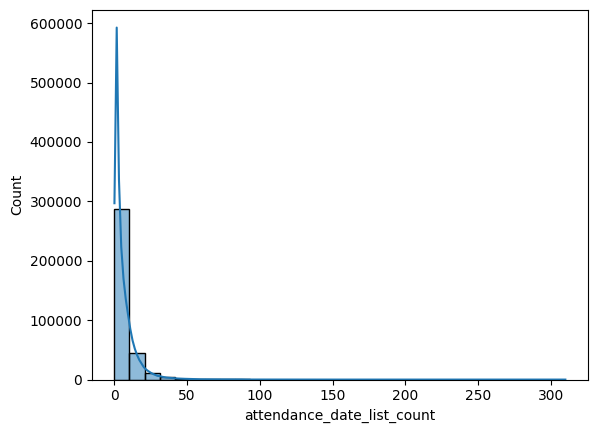

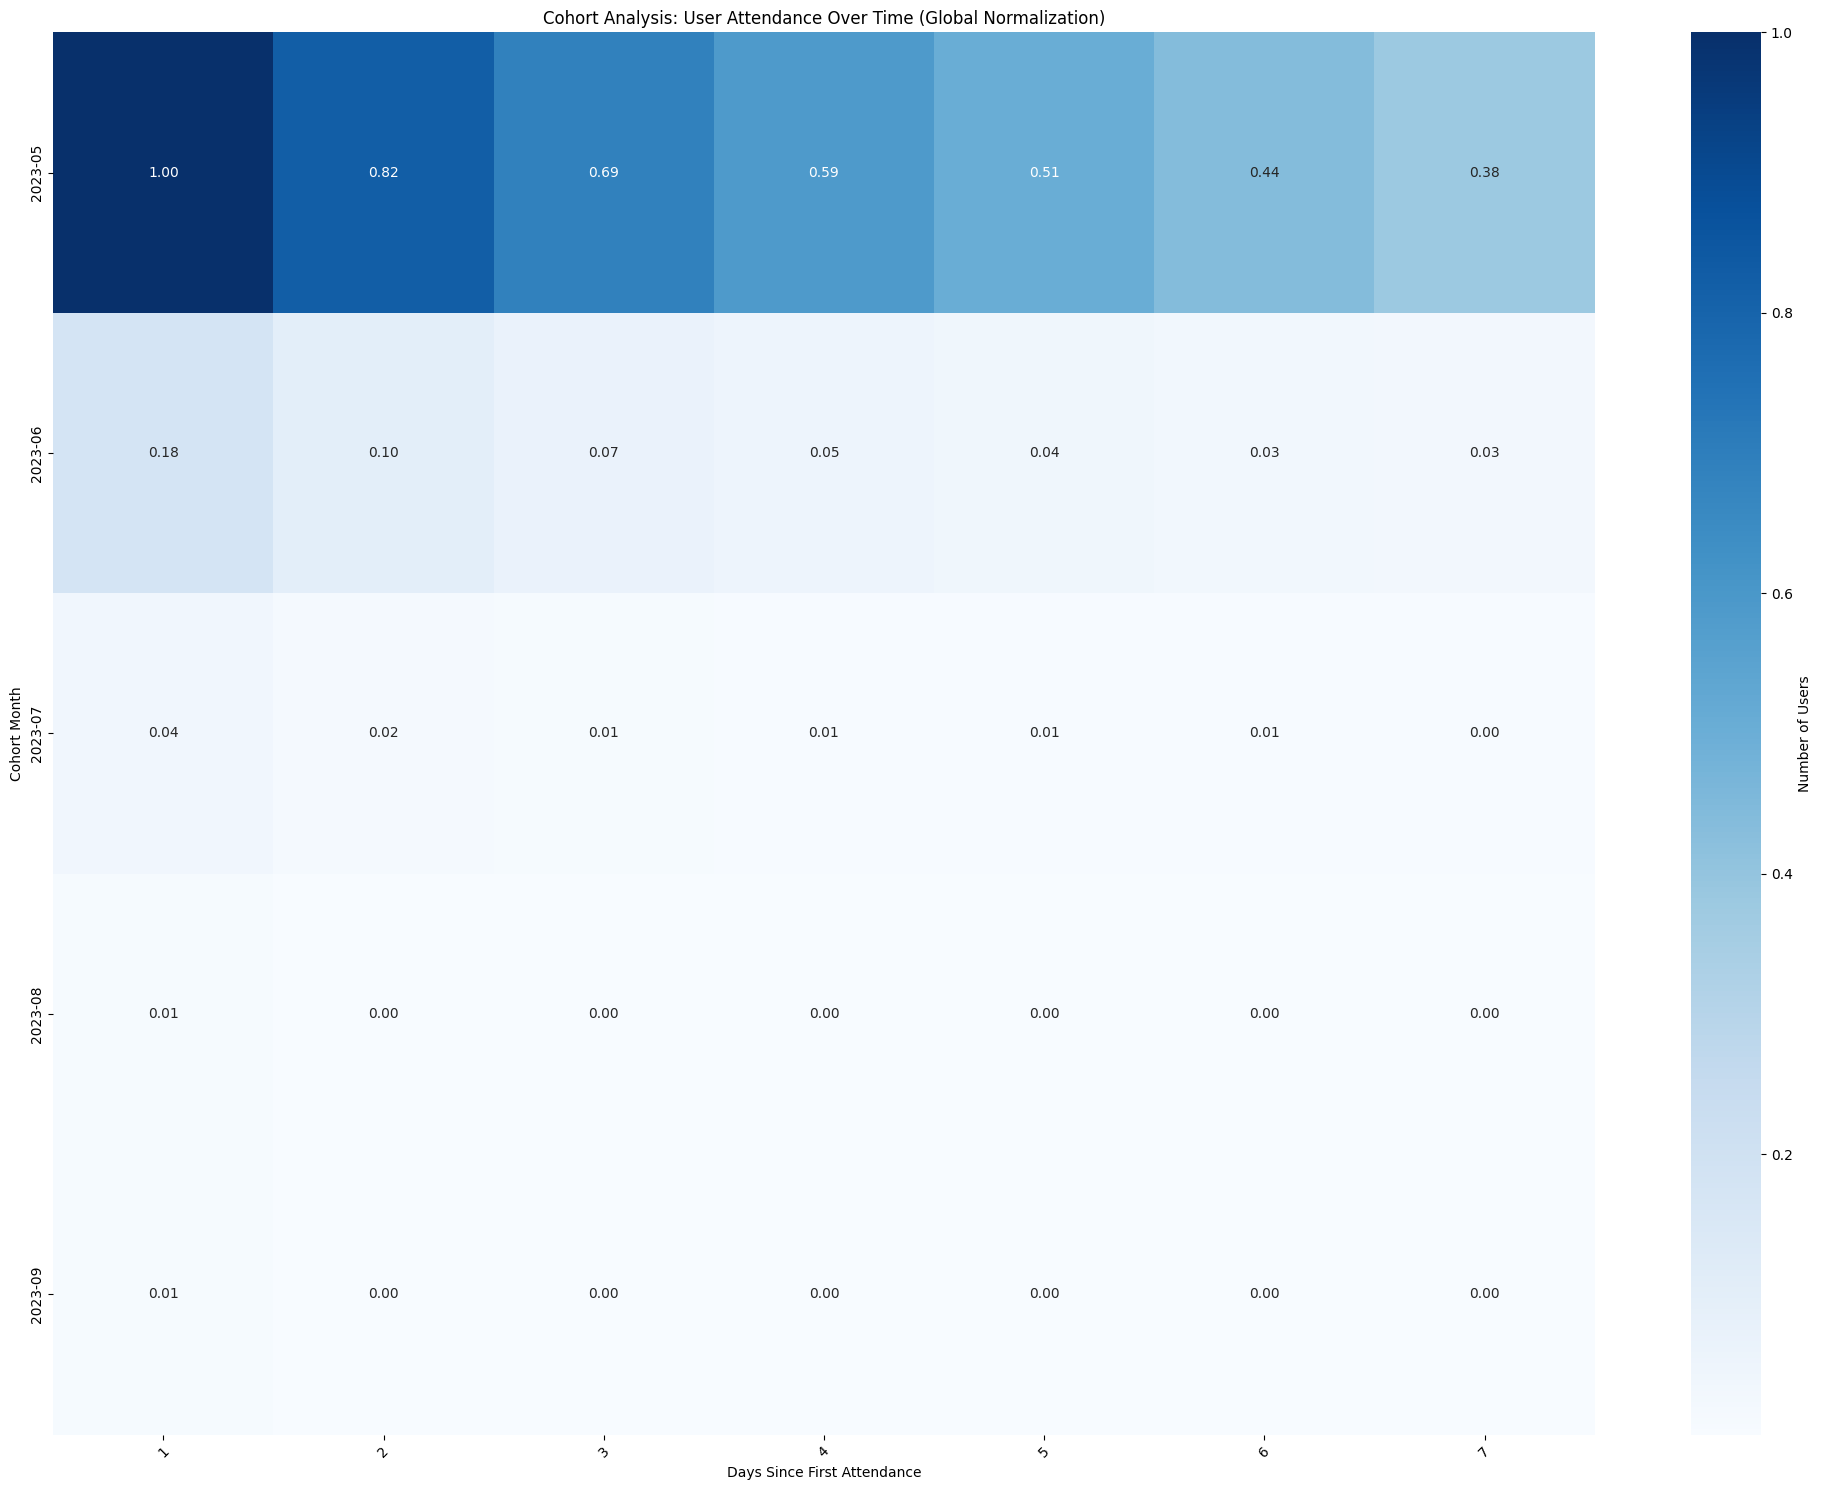

In [ ]:
# 전체 데이터를 조회하기 위한 query 작성
query = """
SELECT *
FROM `votes.accounts_attendance`
"""

# 데이터 불러오기
df = load_data_from_bigquery(query)

# 데이터 내의 longtext로 되어 있는 리스트 형태를 ast.literal_eval로 변환
df['attendance_date_list'] = df['attendance_date_list'].apply(ast.literal_eval)
df['attendance_date_list_count'] = df['attendance_date_list'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# 데이터 조회
display(df.head())

# 데이터의 분포 조회
sns.histplot(data=df['attendance_date_list_count'], bins=30, kde=True)
display(pd.DataFrame(df['attendance_date_list_count'].value_counts().sort_index().reset_index(drop=True)))

# 출석을 진행하지 않은 유저 제거
df = df[df['attendance_date_list_count'] > 0]

# 출석 날짜 리스트의 길이로 인덱스 생성
df['attendance_date_place'] = df['attendance_date_list'].apply(lambda x: list(range(1, len(x) + 1)))

# 데이터 조회
display(df.head())

# explode로 풀기
explode_df = df[['user_id', 'attendance_date_list', 'attendance_date_place']].explode(['attendance_date_list', 'attendance_date_place'])

# 날짜형으로 변환
explode_df['attendance_date'] = pd.to_datetime(explode_df['attendance_date_list'])

# Cohort 기준: 유저의 첫 출석 월
explode_df['cohort'] = explode_df.groupby('user_id')['attendance_date'].transform('min').dt.to_period('M')

# 날짜 차이: 첫 출석 이후 몇 번째인지
explode_df['days_since_first'] = explode_df['attendance_date_place']

# 데이터 조회
display(explode_df.head(30))

# Cohort 분석용 집계
cohort_counts = explode_df.groupby(['cohort', 'days_since_first'])['user_id'].nunique().unstack(fill_value=0)

# 전체 데이터 기준으로 정규화
scaler = MinMaxScaler()
flat_values = cohort_counts.values.flatten().reshape(-1, 1)
scaled_flat = scaler.fit_transform(flat_values)

# 다시 원래 shape로 변형
scaled_values = pd.DataFrame(scaled_flat.reshape(cohort_counts.shape),
                             index=cohort_counts.index,
                             columns=cohort_counts.columns)

# Heatmap 시각화
plt.figure(figsize=(20, 15))
sns.heatmap(scaled_values.iloc[:5, :7], annot=True, fmt='.2f', cmap='Blues', cbar_kws={'label': 'Number of Users'})
plt.title('Cohort Analysis: User Attendance Over Time (Global Normalization)')
plt.xlabel('Days Since First Attendance')
plt.ylabel('Cohort Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 데이터 정리
del df, explode_df, cohort_counts

### polls_question

질문들에 대한 내용들의 유사도를 통해 어떤 키워드를 통해 분류할 수 있는가? 를 알아보기 위함!

In [5]:
query = """
SELECT *
FROM `votes.polls_question`
"""

# 데이터 불러오기
df = load_data_from_bigquery(query)

# 데이터 내의 vote 값을 제거 (이상값 제거)
df = df[df['question_text'] != 'vote']

# 데이터 확인
df

Downloading: 100%|██████████|


,id,question_text,created_at
0,99,가장 신비한 매력이 있는 사람은?,2023-03-31 15:22:53
1,100,"""이 사람으로 한 번 살아보고 싶다"" 하는 사람은?",2023-03-31 15:22:53
2,101,미래의 틱톡커는?,2023-03-31 15:22:54
3,102,여기서 제일 특이한 친구는?,2023-03-31 15:22:54
4,103,가장 지켜주고 싶은 사람은?,2023-03-31 15:22:55
...,...,...,...
5020,5129,나에게 가장 중요한 사람은?,2023-06-06 06:15:52
5021,5130,오목을 제일 잘 할 것 같은 사람은?,2023-06-06 06:15:52
5022,5131,가방에서 쓰레기가 안 나올 것 같은 사람은?,2023-06-06 06:15:52
5023,5132,아무리 많은 숙제도 30분만에 다 끝내버릴 수 있을 것 같은 친구는?,2023-06-06 06:15:52


Pseudo Labeling이라는 준지도학습과 비견되는 분석기법을 통해 분석을 진행!

진행 순서
1. 비지도학습을 통해 데이터의 클러스터링 생성
2. 위의 내용을 바탕으로 클러스터 내부의 질문과 비슷한 데이터를 측정

#### 들어가기 전

유사도 행렬 원본을 그대로 학습하여 클러스터링할 수 있는 기법은 `SpectralClustering`, `Affinity Propagation`이 있다.

또한 벡터 행렬이 아닌 거리 기반 행렬이기 때문에 차원 축소를 진행하기 위해서는 `MDS(다차원척도법)`기법을 사용한 뒤, `KMeans`, `DBSCAN`, `GMM`과 같은 비지도 클러스터링 기법을 사용할 수 있다.

여기서 왜 거리 기반 행렬은 `KMeans`, `DBSCAN`, `GMM`과 같은 내용을 쓸 수 없는지에 대한 내용은 다음과 같다.

- `KMeans`는 다음과 같은 가정 하에 동작한다.
    1. 각 데이터 포인트는 **벡터**로 표현되어 있어야한다.
    2. 클러스터 중심(centroid)을 계산할 수 있어야한다.
        -> 중심은 단순히 벡터들의 평균으로 구함.
    3. 유클리드 거리 기반으로 각 점과 중심 간의 거리를 계산함.

그러나 유사도 행렬은 단지 각 항목 간의 **쌍(pairwise) 관계**만 제공할 뿐, 평균이나 중심을 정의할 수 없고, KMeans와 같은 알고리즘은 이걸 다루는 수학적 매커니즘이 없다.

위의 방식을 통해 `votes.polls_question` 테이블의 `question_text` 의 문장을 통해 유사한 내용을 찾아 클러스터링!

- SentenceTransformer 라이브러리를 이용하여 유사도 거리를 측정함!
    - 이 라이브러리는 Hugging Face에서 사전 훈련된 알고리즘을 사용할 수 있게 하는 라이브러리!
    - 현재 `text-embeddings-inference`에서 가장 많이 다운로드된 한국어 모델은 [`upskyy/bge-m3-korean`](https://huggingface.co/upskyy/bge-m3-korean)
    - 이 모델의 벤치마크의 성능은 다음과 같이 나타났다. 간략하게 설명하면 STS-dev(의미적 텍스트 유사성 벤치마크) 벤치마크에서 코사인 유사도 기준 Peason 0.874, Spearman 0.872로 이는 문장 임베딩이 실제 의미 유사도와 매우 잘 일치함을 나타낸다.
    - 즉, **코사인 유사도**의 상관관계가 가장 높게 나타났기 때문에 텍스트의 유사도 계산은 `cosine_similarity`를 통해 유사도로 선정하게 되는 근간이 될 수 있음.

<`upskyy/bge-m3-korean`의 STS-dev 벤치마크의 결과>

| Metric                  | Value  | 설명                                            |
| ----------------------- | ------ | --------------------------------------------- |
| **pearson\_cosine**     | 0.8740 | 코사인 유사도로 측정한 예측값과 정답 간의 **피어슨 상관계수**          |
| **spearman\_cosine**    | 0.8724 | 코사인 유사도 기반 예측값과 정답 간의 **스피어만 순위 상관계수**        |
| **pearson\_manhattan**  | 0.8593 | 맨해튼 거리 기반 예측값과 정답 간의 **피어슨 상관계수**             |
| **spearman\_manhattan** | 0.8688 | 맨해튼 거리 기반 예측값과 정답 간의 **스피어만 순위 상관계수**         |
| **pearson\_euclidean**  | 0.8598 | 유클리디안 거리 기반 예측값과 정답 간의 **피어슨 상관계수**           |
| **spearman\_euclidean** | 0.8694 | 유클리디안 거리 기반 예측값과 정답 간의 **스피어만 순위 상관계수**       |
| **pearson\_dot**        | 0.8684 | 벡터 내적(dot product) 기반 예측값과 정답 간의 **피어슨 상관계수** |
| **spearman\_dot**       | 0.8666 | 내적 기반 예측값과 정답 간의 **스피어만 순위 상관계수**             |
| **pearson\_max**        | 0.8740 | 여러 유사도 중 가장 좋은 결과의 **피어슨 상관계수**               |
| **spearman\_max**       | 0.8724 | 여러 유사도 중 가장 좋은 결과의 **스피어만 상관계수**              |

In [ ]:
# 모델 로드 및 훈련
model = SentenceTransformer('upskyy/bge-m3-korean')
sentence_embeddings = model.encode(df['question_text'].tolist())

# 코사인 유사도 계산
similarity_matrix = cosine_similarity(sentence_embeddings)

# 코사인 유사도 행렬을 DataFrame으로 변환
similarity_df = pd.DataFrame(similarity_matrix, index=df['question_text'], columns=df['question_text'])
display(similarity_df)

question_text,가장 신비한 매력이 있는 사람은?,"""이 사람으로 한 번 살아보고 싶다"" 하는 사람은?",미래의 틱톡커는?,여기서 제일 특이한 친구는?,가장 지켜주고 싶은 사람은?,내 어깨를 내어줄 수 있는 사람은?,볼 한 번 눌러보고 싶은 사람은?,은근히 애교가 많을 것 같은 사람은?,누가 봐도 좋아할 것 같은 호감인 사람은?,가장 매력적인 사람은?,...,음료 주문을 복잡하게 할 것 같은 사람은?,너무 예쁘고 잘생겨서 이성이 다가가기 어려울 것 같은 사람은?,회사생활 열심히할 것 같은 사람은?,학교가 아닌 곳에서 만났으면 사귈 의향이 있는 친구,도시락 제일 잘 만들 것 같은사람,나에게 가장 중요한 사람은?,오목을 제일 잘 할 것 같은 사람은?,가방에서 쓰레기가 안 나올 것 같은 사람은?,아무리 많은 숙제도 30분만에 다 끝내버릴 수 있을 것 같은 친구는?,러브레터를 가장 잘 쓸 것 같은 사람은?
question_text,,,,,,,,,,,,,,,,,,,,,
가장 신비한 매력이 있는 사람은?,1.000000,0.410686,0.266131,0.552426,0.474227,0.321635,0.367627,0.519694,0.578585,0.782956,...,0.375341,0.489394,0.326980,0.307882,0.303538,0.409576,0.373944,0.311860,0.201999,0.386862
"""이 사람으로 한 번 살아보고 싶다"" 하는 사람은?",0.410686,1.000000,0.273800,0.360163,0.535396,0.397612,0.570965,0.381610,0.509846,0.469007,...,0.311427,0.327447,0.415295,0.430118,0.252519,0.424133,0.283559,0.226453,0.316349,0.313722
미래의 틱톡커는?,0.266131,0.273800,1.000000,0.272000,0.242511,0.219449,0.330143,0.252783,0.204827,0.253516,...,0.246375,0.226270,0.314678,0.177151,0.283342,0.183450,0.324067,0.243374,0.260984,0.235771
여기서 제일 특이한 친구는?,0.552426,0.360163,0.272000,1.000000,0.425457,0.307224,0.305657,0.474853,0.421664,0.426466,...,0.414150,0.349323,0.356584,0.497299,0.276029,0.393529,0.334358,0.331564,0.371862,0.291707
가장 지켜주고 싶은 사람은?,0.474227,0.535396,0.242511,0.425457,1.000000,0.377299,0.442207,0.437088,0.514498,0.483818,...,0.383717,0.369734,0.438712,0.370509,0.286260,0.549298,0.386034,0.352578,0.275076,0.363158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
나에게 가장 중요한 사람은?,0.409576,0.424133,0.183450,0.393529,0.549298,0.447039,0.349730,0.374615,0.397757,0.449892,...,0.291608,0.258367,0.391884,0.310400,0.312401,1.000000,0.323276,0.294526,0.278758,0.374932
오목을 제일 잘 할 것 같은 사람은?,0.373944,0.283559,0.324067,0.334358,0.386034,0.365581,0.354120,0.330209,0.383069,0.377828,...,0.327692,0.283347,0.388620,0.231909,0.497153,0.323276,1.000000,0.241968,0.292384,0.435337
가방에서 쓰레기가 안 나올 것 같은 사람은?,0.311860,0.226453,0.243374,0.331564,0.352578,0.298216,0.182155,0.340846,0.301376,0.303641,...,0.267135,0.211382,0.331875,0.259468,0.296802,0.294526,0.241968,1.000000,0.301467,0.262133


In [ ]:
# 다양한 k값에 대해 Spectral Clustering 수행 후 실루엣 점수 계산
for k in range(2, 11):
    spectral = SpectralClustering(n_clusters=k, affinity='precomputed', random_state=42, eigen_solver='arpack')

    # 거리 행렬로 변환
    # dissimilarity 행렬을 생성하는 이유 : 입력 형태가 n_samples x n_samples 형태의 거리 행렬이기 때문
    labels = spectral.fit_predict(1 - similarity_df)
    
    # Silhouette Score, Davies-Bouldin 점수 계산
    silhouette_avg = silhouette_score(similarity_df, labels, metric='precomputed')
    db_score = davies_bouldin_score(similarity_df, labels)
    print(f'k={k}, Silhouette Score: {silhouette_avg:.4f}, Davies-Bouldin Score: {db_score:.4f}')

KeyboardInterrupt: 

다차원척도법을 통해 가장 최적의 차원을 찾아내는 과정

In [ ]:
demensions = [500, 1000, 1500, 2000, 2500, 3000]

stress_values = []

for dim in demensions:
    mds = MDS(n_components=dim, dissimilarity='precomputed', random_state=42)
    transformed_data = mds.fit_transform(1 - similarity_matrix)
    
    # Stress 계산
    stress = mds.stress_
    stress_values.append(stress)
    print(f'Dimensions: {dim}, Stress: {stress:.4f}')

# Stress 값 시각화
plt.figure(figsize=(10, 6))
plt.plot(demensions, stress_values, marker='o')
plt.title('MDS Stress Values by Dimensions')
plt.xlabel('Number of Dimensions')
plt.ylabel('Stress Value')
plt.grid(True)
plt.xticks(demensions)
plt.grid()
plt.show()

# KneeLocator를 사용하여 최적의 차원 찾기
kneedle = KneeLocator(demensions, stress_values, curve='convex', direction='decreasing')
print(f"Optimal number of dimensions: {kneedle.elbow}")

Dimensions: 500, Stress: 11148.4466
Dimensions: 1000, Stress: 10930.0397
Dimensions: 1500, Stress: 10877.3230
Dimensions: 2000, Stress: 10852.3999


In [22]:
stress_values

[np.float64(857512.3066732592),
 np.float64(223859.09190242083),
 np.float64(85288.13455603705),
 np.float64(35376.70208715476),
 np.float64(24059.456296765067),
 np.float64(17221.502043166693),
 np.float64(13267.416957045887),
 np.float64(13267.416957045887)]

In [ ]:
# 거리 행렬로 변환
# dissimilarity 행렬을 생성하는 이유 : 입력 형태가 n_samples x n_samples 형태의 거리 행렬이기 때문
distance_matrix = 1 - similarity_matrix

# 다양한 k값에 대해 Spectral Clustering 수행 후 실루엣 점수 계산
for k in range(2, 15):
    spectral = SpectralClustering(n_clusters=k, affinity='precomputed', random_state=42)
    labels = spectral.fit_predict(distance_matrix)
    
    # Silhouette Score, Davies-Bouldin 점수 계산
    silhouette_avg = silhouette_score(distance_matrix, labels, metric='precomputed')
    db_score = davies_bouldin_score(distance_matrix, labels)
    print(f'k={k}, Silhouette Score: {silhouette_avg:.4f}, Davies-Bouldin Score: {db_score:.4f}')

클러스터가 잘 된 기준은 다음과 같다.
- `Silhouette Score` 점수가 0.5 이상이면 좋은 편!
- `Davies-Bouldin Score` 점수가 낮을 수록 좋은 편!

In [11]:
# 모델을 순환하며 최적의 k값을 찾는 함수
def find_best_model(model_name):
    # 모델 로드 및 훈련
    model = SentenceTransformer(model_name)
    sentence_embeddings = model.encode(df['question_text'].tolist(), convert_to_tensor=True)

    # 코사인 유사도 계산
    similarity_matrix = model.similarity(sentence_embeddings, sentence_embeddings)

    return similarity_matrix

# 최적의 MDS의 차원 수를 찾기 위한 함수
def mds_selection_func(dim, distance_matrix):
    mds = MDS(n_components=dim, dissimilarity='precomputed', random_state=42)
    mds_coords = mds.fit_transform(distance_matrix)

    return mds_coords

# 다양한 k 값에 대해 Spectral Clustering 수행 및 실루엣 점수 계산
def evaluate_spectral_clustering(similarity_matrix, mds_coords, max_k=10):
    sil_scores = []
    for k in range(2, max_k + 1):
        spectral = SpectralClustering(n_clusters=k, affinity='precomputed', random_state=42)
        labels = spectral.fit_predict(similarity_matrix)

        try:
            score = silhouette_score(mds_coords, labels)
        except:
            score = -1  # 클러스터가 1개일 경우 예외 처리
        sil_scores.append(score)
        print(f"k={k}: Silhouette Score = {score:.3f}")
        
    return sil_scores

def calculate_func(mds_num, similarity_matrix):
    # 클러스터링을 위한 거리 행렬 생성 및 MDS를 통한 2D 임베딩
    # dissimilarity 행렬을 생성하는 이유 : 입력 형태가 n_samples x n_samples 형태의 거리 행렬이기 때문
    # 거리 행렬 생성
    distance_matrix = 1 - similarity_matrix

    # MDS함수 계산
    mds_coords = mds_selection_func(mds_num, distance_matrix)

    # 실루엣 점수 계산
    sil_scores = evaluate_spectral_clustering(similarity_matrix, mds_coords)

    return sil_scores, mds_coords

def create_plt(sil_scores, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, len(sil_scores) + 2), sil_scores, marker='o')
    plt.title(f'Silhouette Scores for {model_name}')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.xticks(range(2, len(sil_scores) + 2))
    plt.grid()
    plt.show()


In [ ]:
# similarity_matrix는 질문 간 유사도 DataFrame이라고 가정
similarity_matrix = similarity_df.values

# Spectral Clustering은 유사도 행렬 사용 가능
spectral = SpectralClustering(n_clusters=2, affinity='precomputed', random_state=42)
labels = spectral.fit_predict(similarity_matrix)

# 결과 보기
for question, label in zip(similarity_df.index, labels):
    print(f"[Cluster {label}] {question}")

# 거리 행렬 = 1 - similarity
distance_matrix = 1 - similarity_matrix

# MDS로 2D 임베딩
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_coords = mds.fit_transform(distance_matrix)

# Spectral Clustering 라벨 사용
sil_score = silhouette_score(mds_coords, labels)
print(f"Spectral Clustering Silhouette Score: {sil_score:.3f}")

[Cluster 0] 가장 신비한 매력이 있는 사람은?
[Cluster 0] "이 사람으로 한 번 살아보고 싶다" 하는 사람은?
[Cluster 1] 미래의 틱톡커는?
[Cluster 1] 여기서 제일 특이한 친구는?
[Cluster 0] 가장 지켜주고 싶은 사람은?
[Cluster 0] 내 어깨를 내어줄 수 있는 사람은?
[Cluster 0] 볼 한 번 눌러보고 싶은 사람은?
[Cluster 0] 은근히 애교가 많을 것 같은 사람은?
[Cluster 0] 누가 봐도 좋아할 것 같은 호감인 사람은?
[Cluster 0] 가장 매력적인 사람은?
[Cluster 1] 와플을 좋아하는 친구는?
[Cluster 0] 내가 성별이 바뀐다면 만나고 싶은 사람은?
[Cluster 0] 마스크가 잘 어울리는 사람은?
[Cluster 0] 싸울 때 반드시 내 편에 두고 싶은 사람은?
[Cluster 0] 첫인상과 아예 반대라고 느낀 사람은?
[Cluster 0] 화나면 가장 무서울 것 같은 사람은?
[Cluster 0] 비율이 가장 좋은 사람은?
[Cluster 0] 대학가서 용될것 같은 사람은?
[Cluster 1] 조용한 매력이 있는 친구
[Cluster 0] 샤워 1시간 동안 할 것 같은 사람은?
[Cluster 0] 시간 약속을 제일 잘 지킬것 같은 사람은?
[Cluster 0] 본인 방이 제일 깨끗할거 같은 사람은?
[Cluster 0] 가장 어른스러운 사람은?
[Cluster 0] 비밀을 털어놓을 수 있는 사람은?
[Cluster 0] 의리하면 떠오르는 사람은?
[Cluster 0] 힘든 일이 있을때 털어놓고 얘기하고싶은 사람은?
[Cluster 1] 10년 후 1명에게만 연락할 수 있다면 누구한테 하고 싶어?
[Cluster 0] 가장 연애를 많이 했을 것 같은 사람은?
[Cluster 0] 같이 벚꽃보러 가고 싶은 사람은?
[Cluster 0] 결혼을 가장 빨리 할 것 같은 사람은?
[Cluster 0] 길에서 자주 번호를 따여봤을 것 같은 사람은?
[Clust